# Statistics Group 12 - Final Project

### Data Structure
A dataset containing 1311 entries on 6 variables, for 57 countries over 23 years. The variables are as follows:

- **Year**: The year of observation
- **GDP Growth**: Annual GDP growth rate
- **GFCF change**: Gross Fixed Capital Formation change
- **Inflation change**: Percentage change in inflation
- **Unemployment change**: Percentage change in unemployment (some entries may have null values)

### Objective 
Predict the GDP growth rate with the other variables as predictors.

In [132]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

# For modeling
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

# Import OLS 
import statsmodels.api as sm

# Import data
data = pd.read_csv('../Data/economic_indicators.csv', index_col=0)

#### Check correlations

In [2]:
data_explore = data.drop('Year', axis=1)
data_explore.corr().style.background_gradient(cmap='coolwarm')

,GDP Growth,GFCF change,Inflation change,Unemployment change
GDP Growth,1.000000,0.583332,-0.086875,-0.386171
GFCF change,0.583332,1.000000,0.135399,-0.346725
Inflation change,-0.086875,0.135399,1.000000,-0.047444
Unemployment change,-0.386171,-0.346725,-0.047444,1.000000


#### Check VIF

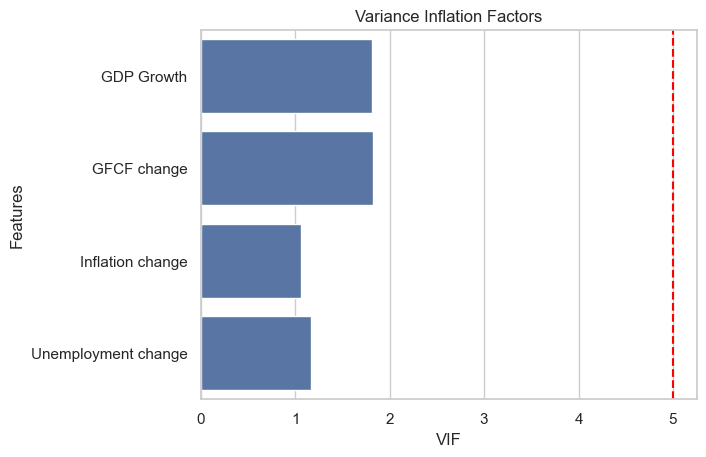

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the VIF with confidence intervals
variables = data_explore
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif.round(1)

# Plot the VIF
sns.set(style="whitegrid")
ax = sns.barplot(x="VIF", y="Features", data=vif)
# Add a line on 5
plt.axvline(x=5, color='red', linestyle='--')
plt.title('Variance Inflation Factors')
plt.show()

#### Check for interactions with the target variable

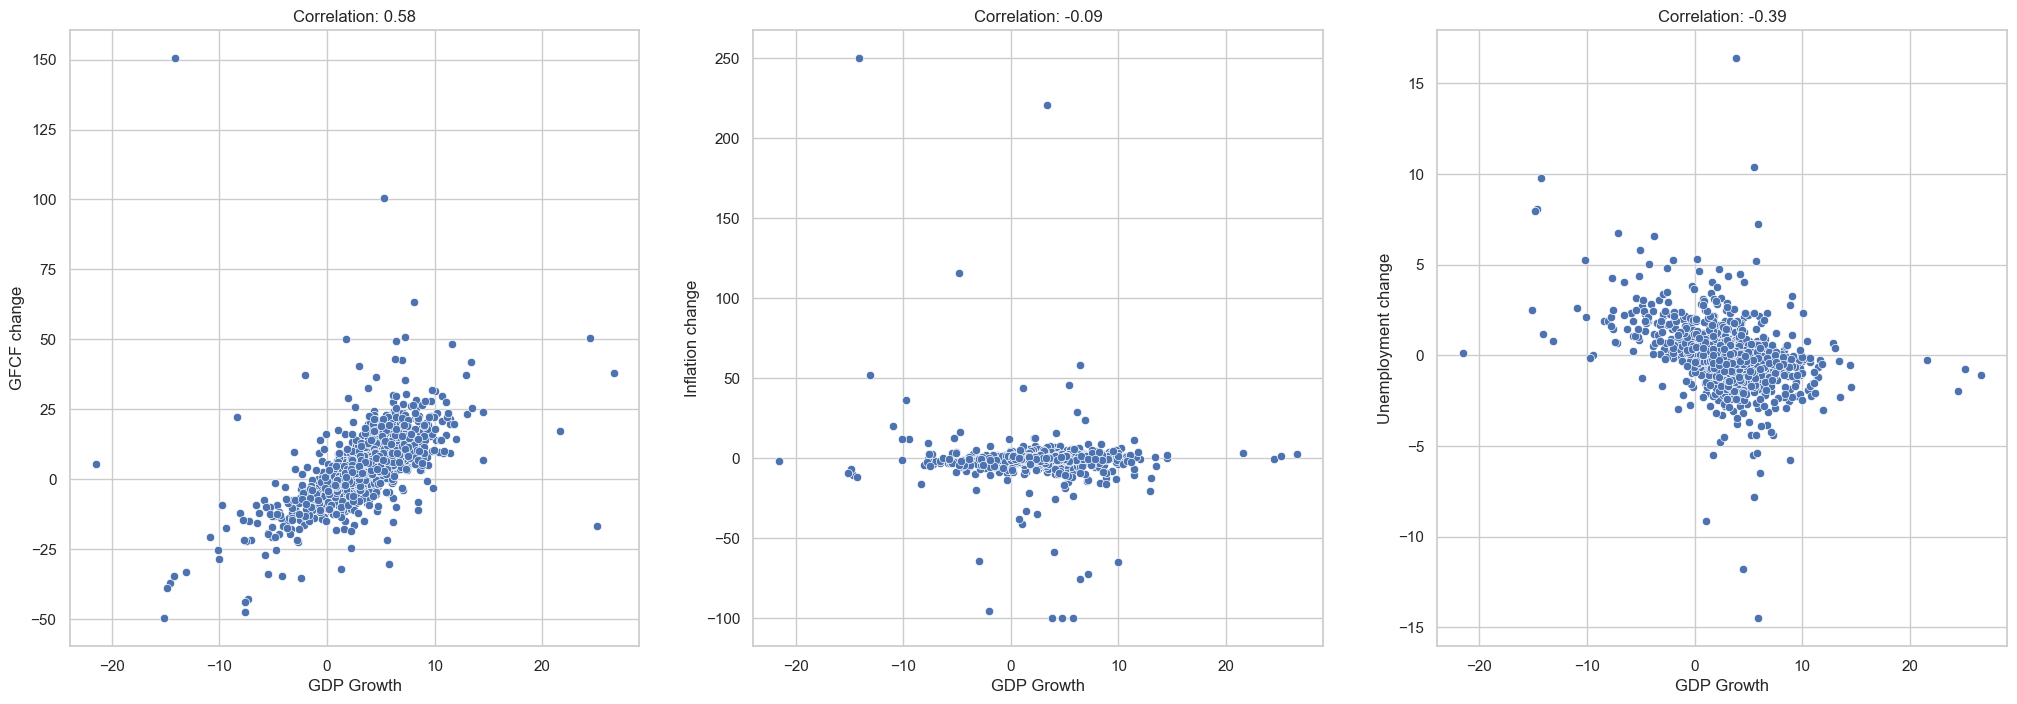

In [44]:
data_explore['Country'] = data.index

# Plot scatterplots of the variables against the GDP Growth
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
sns.scatterplot(x="GDP Growth", y="GFCF change", data=data_explore, ax=axs[0])
sns.scatterplot(x="GDP Growth", y="Inflation change", data=data_explore, ax=axs[1])
sns.scatterplot(x="GDP Growth", y="Unemployment change", data=data_explore, ax=axs[2])
corrs = data_explore.drop('Country', axis=1).corr().round(2)
for i in range(len(axs)):
    axs[i].set_title('Correlation: ' + str(corrs.iloc[0, i+1]))
    axs[i].set_xlabel('GDP Growth')
plt.show()

We are not convienced with the results, especially as we know that inflation has a positive relationship with GDP growth

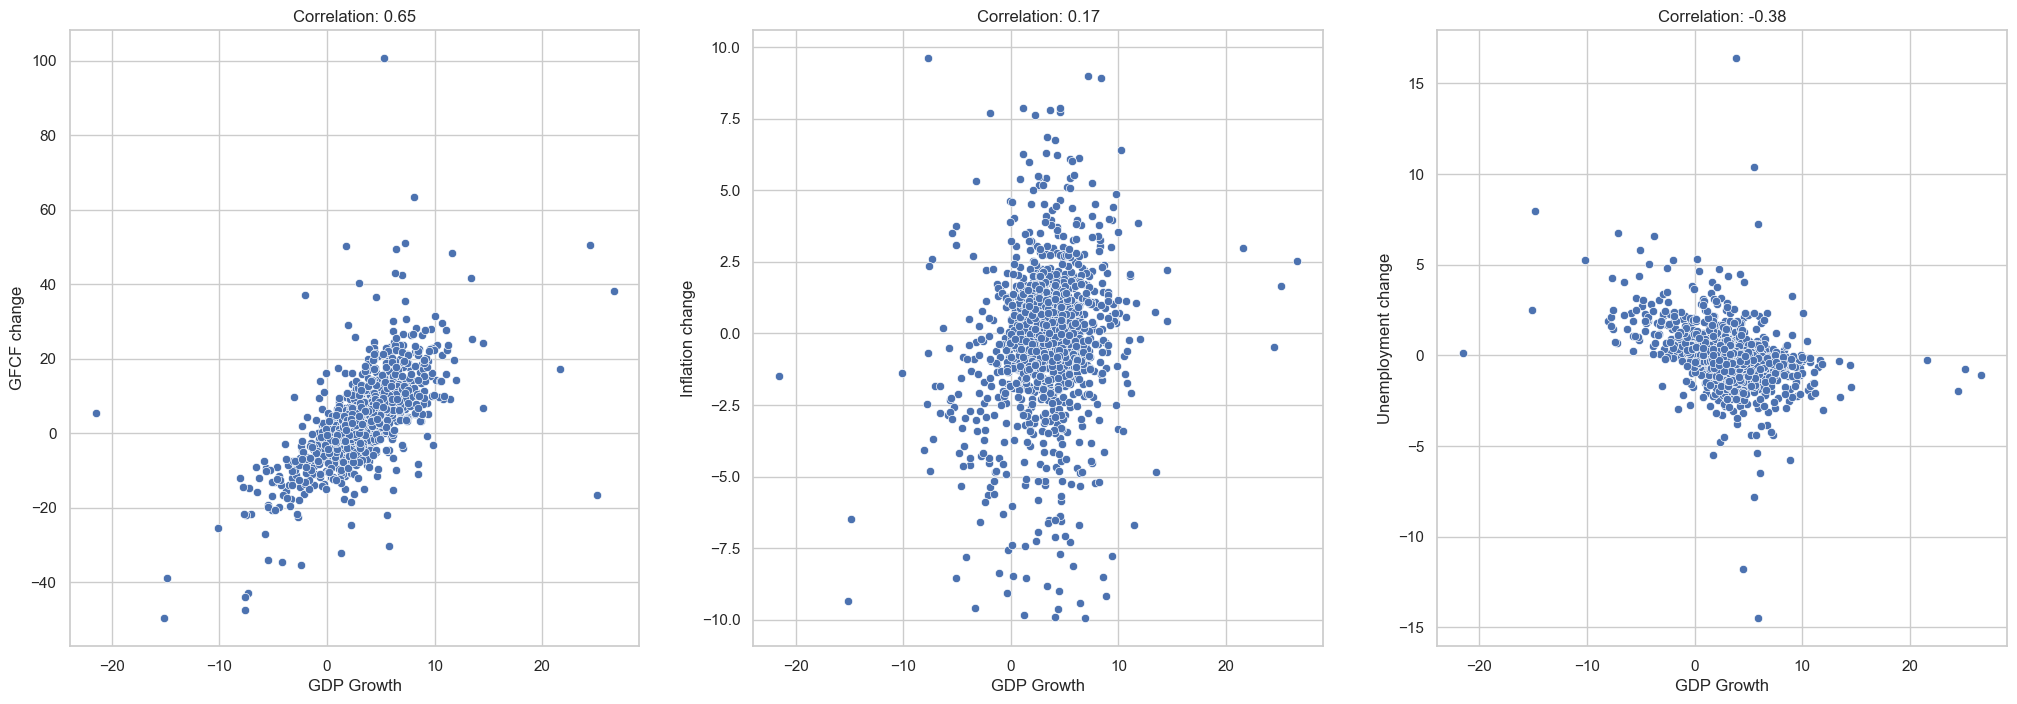

In [87]:
# Lets cap the inflation at -5, 5
data_inf_capped = data[np.abs(data['Inflation change']) <= 10]

# Plot scatterplots of the variables against the GDP Growth
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
sns.scatterplot(x="GDP Growth", y="GFCF change", data=data_inf_capped, ax=axs[0])
sns.scatterplot(x="GDP Growth", y="Inflation change", data=data_inf_capped, ax=axs[1])
sns.scatterplot(x="GDP Growth", y="Unemployment change", data=data_inf_capped, ax=axs[2])
corrs = data_inf_capped.drop('Year', axis=1).corr().round(2)

for i in range(len(axs)):
    axs[i].set_title('Correlation: ' + str(corrs.iloc[0, i+1]))
    axs[i].set_xlabel('GDP Growth')
plt.show()

## Pooled OLS

In [92]:
X = data_inf_capped[['GFCF change','Unemployment change', 'Inflation change']]
y = data_inf_capped['GDP Growth']

# Add constant to X
X = sm.add_constant(X)

# Fit OLS
pooled_ols = sm.OLS(y, X).fit() 

# Print summary table
print(pooled_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP Growth   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     396.2
Date:                Fri, 12 Jan 2024   Prob (F-statistic):          2.23e-187
Time:                        19:13:26   Log-Likelihood:                -3342.5
No. Observations:                1437   AIC:                             6693.
Df Residuals:                    1433   BIC:                             6714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.3588    

#### Are residuals normally distributed?


- Looking at the Jarque-Bera and omnibus tests, we have non normality in the residuals
- This doesnt mean that the estimator isnt the BLUE (!)

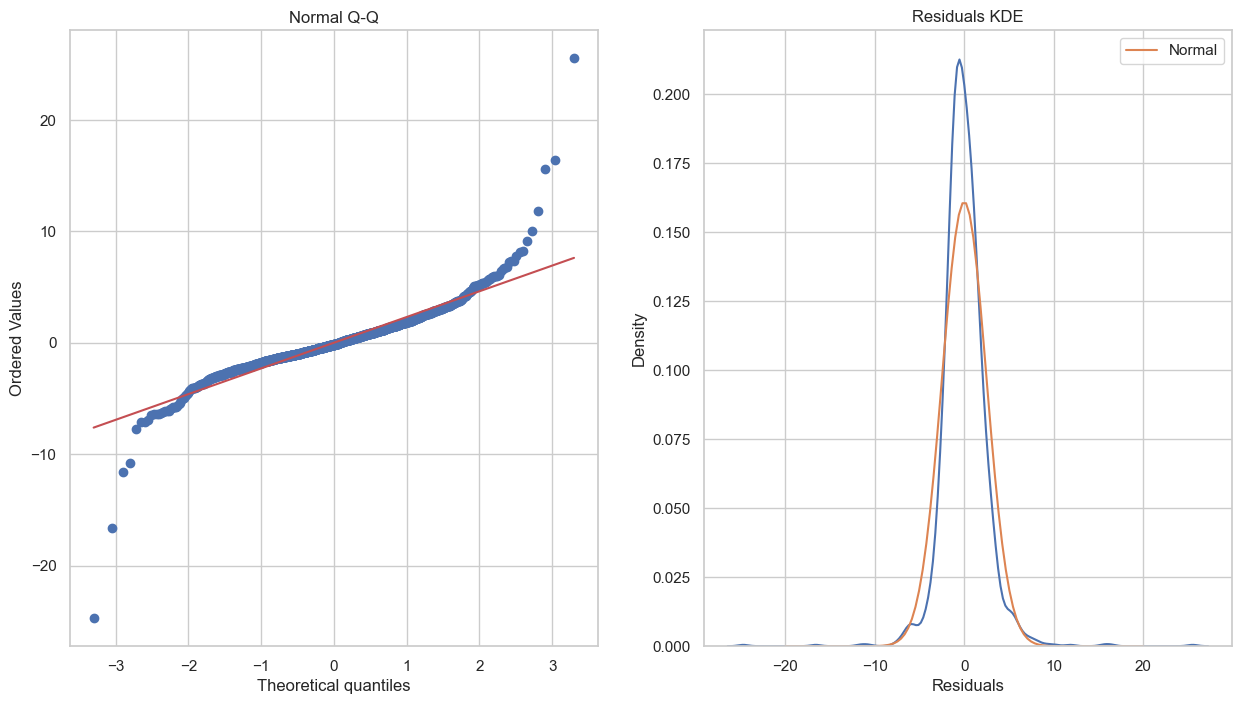

In [115]:
# Lets look at the Q-Q plot of the residuals
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,8), nrows=1, ncols=2)
_, (__, ___, r) = st.probplot(pooled_ols.resid, plot=ax[0], fit=True)


sns.kdeplot(pooled_ols.resid, ax=ax[1])

# Estimate the normal distribution
mean, std = st.norm.fit(pooled_ols.resid)
ax[1].plot(np.linspace(-20,20,100), st.norm.pdf(np.linspace(-20,20,100), mean, std), label='Normal')
ax[1].legend()
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Density')
ax[1].set_title('Residuals KDE')
ax[0].set_title('Normal Q-Q')
plt.show()

#### Are the residuals homoskedastic?

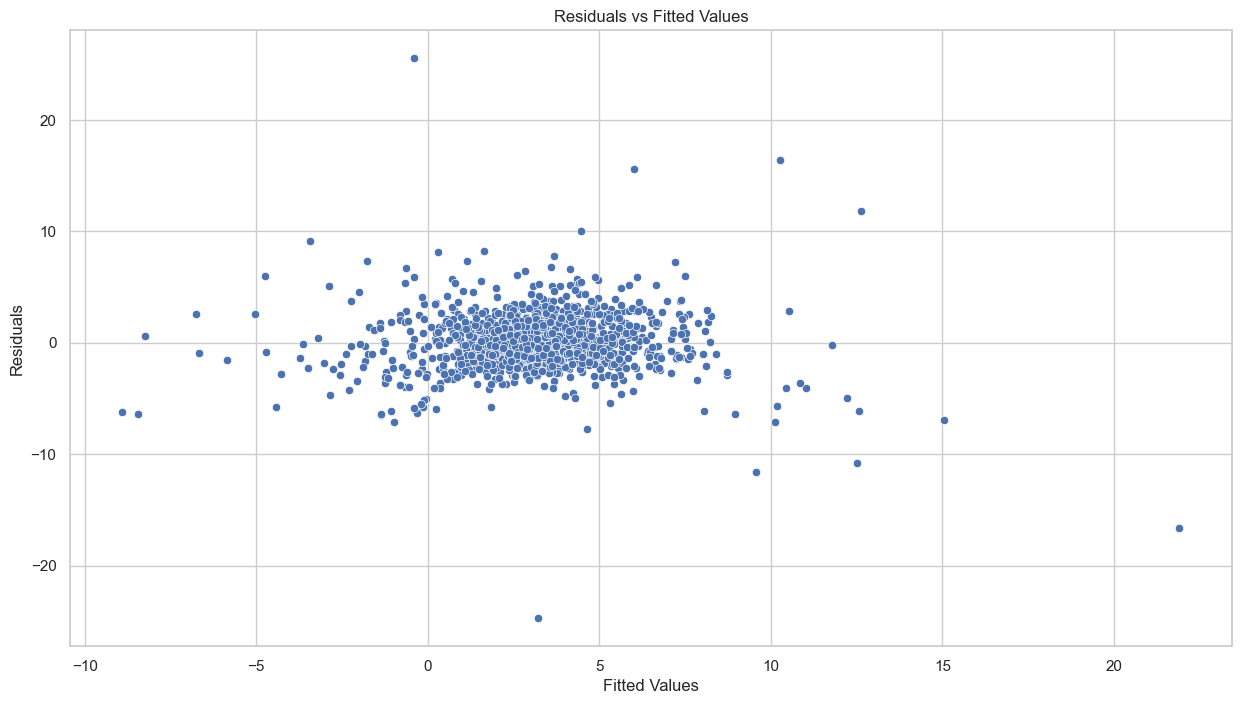

In [129]:
# Plot residuals vs X
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.scatterplot(x=pooled_ols.fittedvalues, y=pooled_ols.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

From the plot we couldn't be sure. Lets use the breusch pagan and white test to check

In [134]:
# Run breusch pagan and white heteroskedasticity test
_, pval_w, ___, f_pval_w = het_white(pooled_ols.resid, X)
_, pval_bp, ___, f_pval_bp = het_breuschpagan(pooled_ols.resid, X)

print('White Heteroskedasticity Test p-value: ', pval_w)
print('White Heteroskedasticity Test F-statistic p-value: ', f_pval_w)

print('Breusch Pagan Heteroskedasticity Test p-value: ', pval_bp)
print('Breusch Pagan Heteroskedasticity Test F-statistic p-value: ', f_pval_bp)

White Heteroskedasticity Test p-value:  6.962308689355929e-28
White Heteroskedasticity Test F-statistic p-value:  1.7144047975360292e-29
Breush Pagan Heteroskedasticity Test p-value:  0.0038234356939660795
Breush Pagan Heteroskedasticity Test F-statistic p-value:  0.003769914420711248


- Clearly there is heteroskedasticity -> Gauss-Markov assumptions are violated -> OLS isnt the BLUE
- Are the residuals correlated with the endogenous variable? Lets visually inspect (exogeneity)

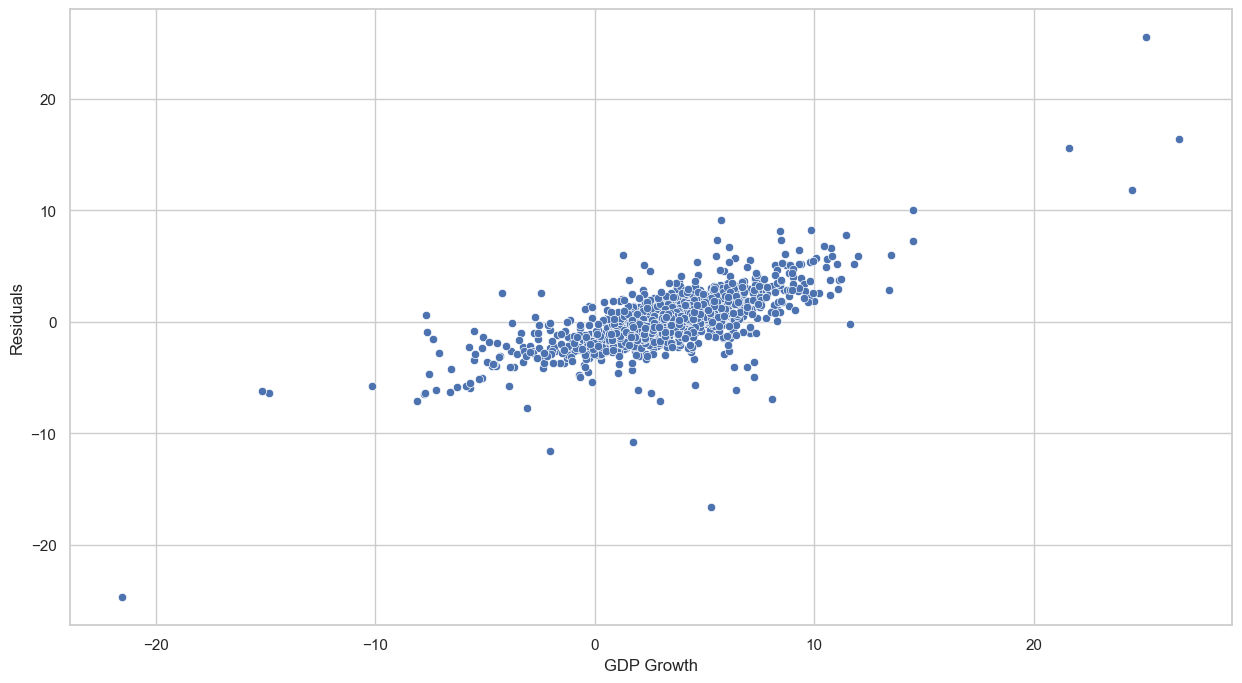

In [139]:
# Scatterplot of residuals vs gdp growth
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.scatterplot(x=data_inf_capped['GDP Growth'], y=pooled_ols.resid)
plt.xlabel('GDP Growth')
plt.ylabel('Residuals')
plt.show()

Are residuals autocorrelated?

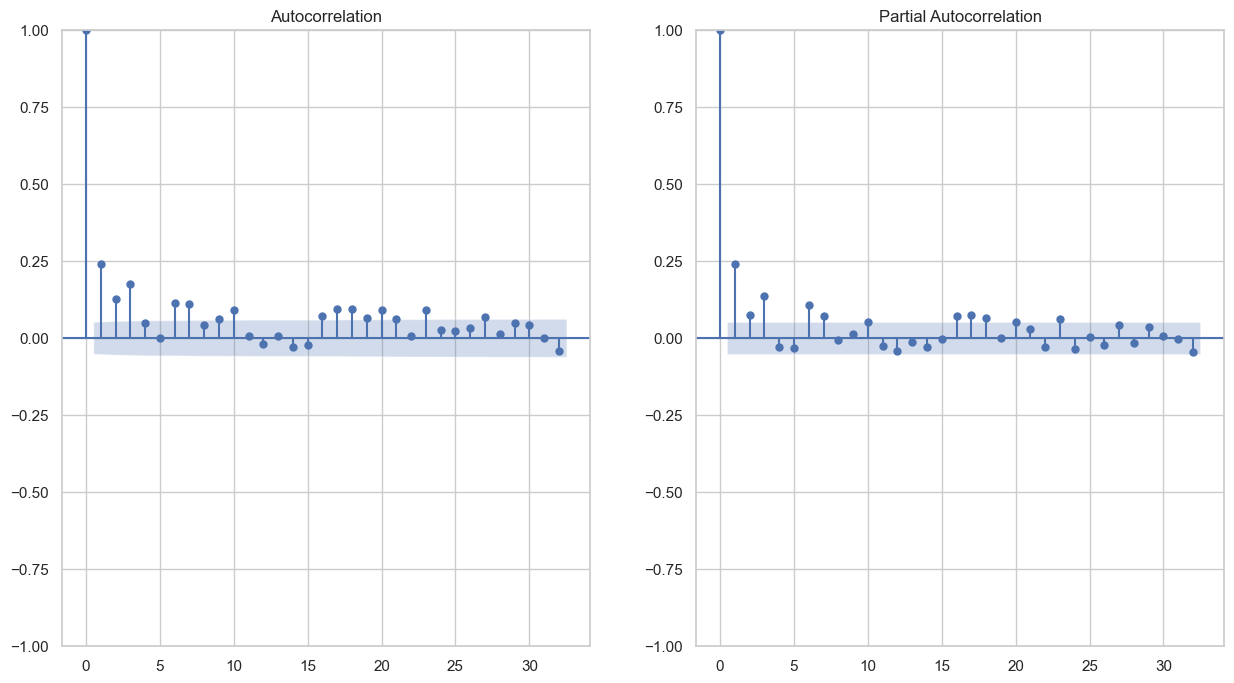

In [140]:
# Check for autocorrelation of the residuals
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,8), nrows=1, ncols=2)
tsap.plot_acf(pooled_ols.resid, ax=ax[0])
tsap.plot_pacf(pooled_ols.resid, ax=ax[1])
ax[0].set_title('Autocorrelation')
ax[1].set_title('Partial Autocorrelation')
plt.show()

Definetely autocorrelation. Lets move on to the fixed effects estimator. Why the errors? 

## Fixed Effects

In [167]:
X_fe = data_inf_capped[['GFCF change','Unemployment change', 'Inflation change']].copy()
y = data_inf_capped['GDP Growth']

# Add the country name to the X
X_fe['Country'] = X_fe.index

# Create dummy variables for the countries
X_fe = pd.get_dummies(X_fe, columns=['Country'], drop_first=False)

# Remove country Germany
X_fe = X_fe.drop('Country_Germany', axis=1)

# Remove Country_ from columns
X_fe.columns = [col.replace('Country_', '') for col in X_fe.columns]

# Change True and False to 1 and 0
X_fe = X_fe.replace(True, 1)
X_fe = X_fe.replace(False, 0)

In [168]:
# Fit the model 
fixed_effects = sm.OLS(y, X_fe).fit()

# Print summary table
print(fixed_effects.summary())

                                 OLS Regression Results                                
Dep. Variable:             GDP Growth   R-squared (uncentered):                   0.751
Model:                            OLS   Adj. R-squared (uncentered):              0.739
Method:                 Least Squares   F-statistic:                              61.79
Date:                Fri, 12 Jan 2024   Prob (F-statistic):                        0.00
Time:                        20:12:54   Log-Likelihood:                         -3227.2
No. Observations:                1437   AIC:                                      6588.
Df Residuals:                    1370   BIC:                                      6941.
Df Model:                          67                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------